In [270]:
#
import pandas
from statsmodels.tsa.seasonal import MSTL
from matplotlib import pyplot
from scipy import stats
import seaborn
#
import numpy
from sklearn.ensemble import RandomForestRegressor

#
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mutual_info_score
from scipy.stats import kendalltau
from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import PowerTransformer

import umap
import hdbscan
# from umap.parametric_umap import ParametricUMAP
from sklearn.decomposition import PCA, SparsePCA, KernelPCA

In [192]:
# driver = 'JTU5300QUL'
# driver = 'QUSR628BIS'
# driver = 'RAILFRTCARLOADSD11'
# driver = 'FRGSHPUSM649NCIS'
driver = 'TSIFRGHT'
# driver = 'AIRRTMFMD11'
# driver = 'CUUR0000SEHA'
series = pandas.read_csv('./data/{0}.csv'.format(driver))
# series = data[[driver]].copy()
# series = series.reset_index().rename(columns={'jx': 'ds', driver: 'y'})
series = series.rename(columns={'DATE': 'ds', driver: 'y'})
series['ds'] = pandas.to_datetime(series['ds'])
series['y'] = series['y'].apply(func=lambda x: pandas.NA if x == '.' else x)
series['y'] = series['y'].ffill()
series['y'] = pandas.to_numeric(series['y'])
series = series[series['ds'] > '1970-01-01']
series = series.rename(columns={'ds': 'DATE', 'y': driver})
# series['y'] = series['y'].pct_change()
# series = series[series['ds'] > '2000-01-01']
series

,DATE,TSIFRGHT
0,2000-01-01,105.1
1,2000-02-01,103.3
2,2000-03-01,99.7
3,2000-04-01,97.9
4,2000-05-01,98.8
...,...,...
279,2023-04-01,136.0
280,2023-05-01,136.8
281,2023-06-01,136.8
282,2023-07-01,138.2


In [193]:
d = './result_model_medieval.csv'
data = pandas.read_csv(d)
data

,jx,A091RC1Q027SBEA,A229RX0,A824RL1Q225SBEA,AAA,AIRRTMFMD11,AWHAERT,AWHMAN,BAA,BAMLC0A0CM,...,TERMCBCCINTNS__full_binners_20_smile,TLT__full_binners_20_smile,TLT_MEAN__full_binners_20_smile,TOTALSA__full_binners_20_smile,TSIFRGHT__full_binners_20_smile,UNRATE__full_binners_20_smile,USACPIALLMINMEI__full_binners_20_smile,USEPUINDXM__full_binners_20_smile,USTRADE__full_binners_20_smile,W006RC1Q027SBEA__full_binners_20_smile
0,2007-01-31,376.299,37850.0,-7.8,5.32,3289635.0,31.7,41.1,6.20,1.297937,...,0.006515,0.575604,0.000000,0.584821,0.007228,0.294118,1.0,0.340586,0.000570,0.001303
1,2007-02-28,386.925,38000.0,12.8,5.40,3374429.0,31.7,41.0,6.22,1.297937,...,0.006515,0.000000,0.000000,0.760267,0.021684,0.352941,1.0,0.000000,0.000570,0.001628
2,2007-03-30,386.925,37962.0,12.8,5.39,3356636.0,31.5,40.9,6.34,1.297937,...,0.006515,0.575604,0.000000,0.643303,0.014456,0.294118,1.0,0.340586,0.000570,0.001628
3,2007-04-30,386.925,38055.0,12.8,5.30,3332574.0,31.7,41.3,6.28,1.297937,...,0.005429,0.000000,0.582306,0.760267,0.021684,0.294118,1.0,0.340586,0.000697,0.001628
4,2007-05-31,396.009,38145.0,-3.3,5.47,3374477.0,31.6,41.3,6.27,1.297937,...,0.005429,0.575604,0.582306,0.526339,0.036140,0.294118,1.0,0.340586,0.000633,0.001954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2023-08-31,909.584,46795.0,2.3,4.66,3901916.0,29.9,40.6,5.75,1.220000,...,1.000000,0.019759,0.020056,0.584821,0.108421,0.000000,0.0,0.057293,0.000824,0.005536
200,2023-09-29,909.584,46795.0,2.3,4.66,3980447.0,29.9,40.6,5.74,1.240000,...,1.000000,0.019759,0.013371,0.526339,0.122877,0.000000,0.0,0.057293,0.000824,0.005536
201,2023-10-31,909.584,46795.0,2.3,4.66,3978655.0,29.8,40.6,5.74,1.320000,...,1.000000,0.019759,0.582306,0.467857,0.122877,0.000000,0.0,0.057293,0.000887,0.005536
202,2023-11-30,981.305,46795.0,8.0,4.66,3978655.0,29.8,40.6,5.74,1.320000,...,1.000000,0.019759,0.000000,0.526339,0.122877,0.000000,0.0,0.057293,0.000887,0.005536


In [194]:
# series.set_index('ds').iloc[80:120, :].plot(style='.')  # '.-'

<Axes: >

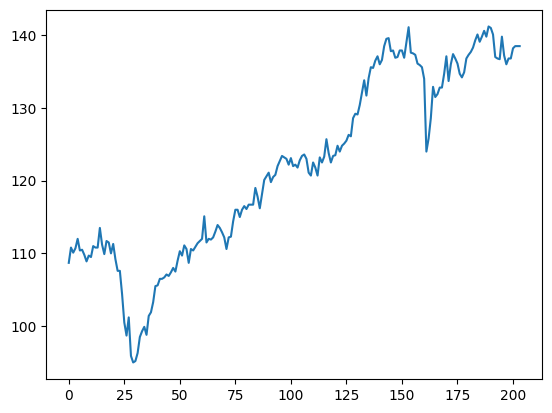

In [195]:
data[driver].plot()

<Axes: >

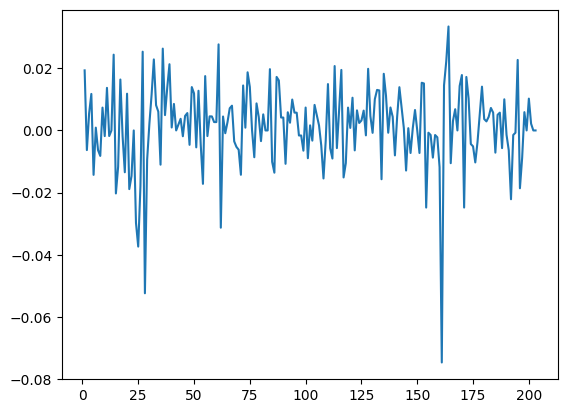

In [196]:
data[driver].pct_change().plot()

In [197]:
def make_lags(frame, nl):
    cols = frame.columns.values
    for j in range(nl):
        cols_lagged = ['{0}_LAG{1}'.format(c, j+1) for c in cols]
        frame[cols_lagged] = frame[cols].shift(j+1)
    return frame

In [302]:
f = driver
l = 40
target = 'IVV_MEAN__pct'
data_lag = data.iloc[:100, :].loc[:, [f, target]].copy()
data_app = data.iloc[100:, :].loc[:, [f, target]].copy()

data_joint = pandas.concat((data_lag, data_app), axis=0, ignore_index=True)
data_joint = make_lags(frame=data_joint, nl=l)

data_joint[driver] = data_joint[driver].pct_change()

# .iloc[data_lag.shape[0]:, :]

x_factors = [c for c in data_joint.columns if ((f in c) and ('LAG' in c))]

sub_train = data_joint.iloc[l:data_lag.shape[0], :].copy()
x_sub_train = sub_train[[f]].values
"""
# disc = KBinsDiscretizer(n_bins=2, strategy='quantile', encode='ordinal')
# disc = KBinsDiscretizer(n_bins=7, strategy='kmeans', encode='ordinal', subsample=None)
te = TargetEncoder(target_type='continuous')
tar_ts = PowerTransformer()
x_ts = PowerTransformer()
# tar_transformed = sub_train[target].values
# tar_transformed = tar_ts.fit_transform(X=sub_train[[target]].values)[:, 0]
# x_sub_train = x_ts.fit_transform(X=x_sub_train)
# x_sub_train_transformed = disc.fit_transform(X=x_sub_train)
x_sub_train_transformed = disc.fit_transform(X=x_sub_train, y=tar_transformed)
x_sub_train_transformed
"""

"""
tar_transformed = sub_train[target].values
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=12,
    random_state=42,
).fit_transform(X=x_sub_train, y=tar_transformed)
# ).fit_transform(X=x_sub_train)
x_sub_train_transformed = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=10,
).fit_predict(clusterable_embedding).reshape(-1, 1)
x_sub_train_transformed
"""

disc = PCA(n_components=0.99, whiten=True)
# disc = PCA(n_components='mle', whiten=True)
x_sub_train_transformed = disc.fit_transform(X=sub_train[x_factors])
len(x_factors), x_sub_train_transformed.shape[1]

array([[  6.15938888,  -2.2970297 ,  -3.62871287, ...,  13.53465347,
         15.04950495,  14.38778878],
       [  6.20628494,  -2.0990099 ,  -2.34158416, ...,  14.42574257,
         13.96039604,  12.20957096],
       [  4.81033833,  -3.58415842,  -4.12376238, ...,  14.22772277,
         11.78217822,  11.41749175],
       ...,
       [ -4.76124609,  -5.56435644,  -4.61881188, ...,  -8.14851485,
         -7.72277228,  -9.17656766],
       [ -6.39360597,  -6.45544554,  -4.71782178, ...,  -6.56435644,
         -9.6039604 ,  -9.67161716],
       [ -4.66320784,  -6.05940594,  -6.7970297 , ...,  -8.54455446,
        -10.0990099 , -10.16666667]])

In [279]:
pandas.Series(x_sub_train_transformed[:, 0]).value_counts()

-1.164088    1
-1.217642    1
 0.261511    1
 0.300901    1
 0.337432    1
 0.384431    1
 0.435569    1
 0.485779    1
 0.525752    1
 0.571496    1
 0.620800    1
 0.664975    1
 0.712156    1
 0.756723    1
 0.799859    1
 0.857086    1
 0.904097    1
 0.939922    1
 0.989202    1
 1.049275    1
 1.114192    1
 1.182546    1
 1.239817    1
 1.303491    1
 1.366620    1
 1.433573    1
 1.506773    1
 1.582578    1
 1.656165    1
 0.231079    1
 0.185524    1
 0.129117    1
-1.117328    1
-1.259369    1
-1.298684    1
-1.329771    1
-1.349508    1
-1.365583    1
-1.370355    1
-1.364676    1
-1.356732    1
-1.330104    1
-1.288011    1
-1.241558    1
-1.180673    1
-1.057661    1
 0.061754    1
-0.984739    1
-0.912062    1
-0.830026    1
-0.742345    1
-0.652324    1
-0.555876    1
-0.440730    1
-0.352274    1
-0.260380    1
-0.175754    1
-0.098246    1
-0.021171    1
 1.727476    1
Name: count, dtype: int64

<Axes: >

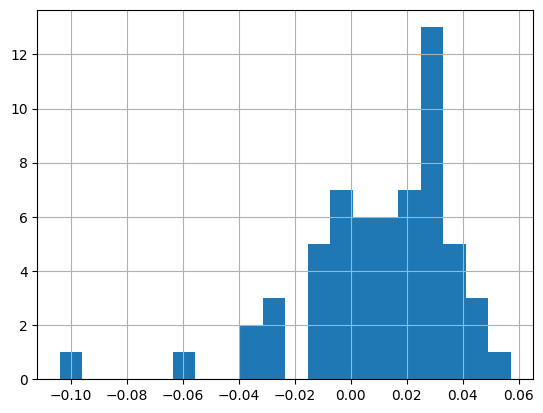

In [280]:
pandas.Series(tar_transformed).hist(bins=20)

<Axes: >

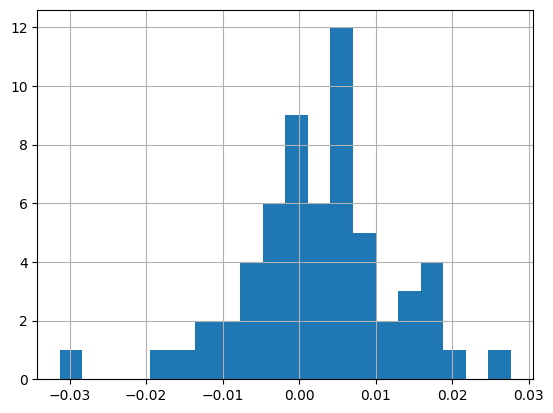

In [281]:
pandas.Series(x_sub_train[:, 0]).hist(bins=20)

<Axes: >

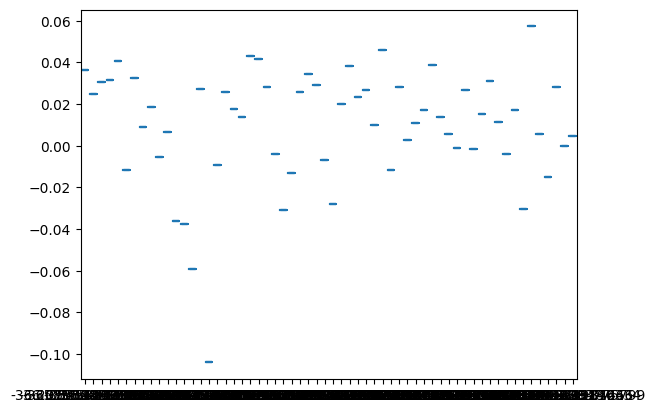

In [275]:
fs = pandas.DataFrame(data={'x': x_sub_train_transformed[:, 0], 'y': sub_train[target].values, 'o': sub_train[f].values})
# pyplot.scatter(fs['x'].values, fs['y'].values)
seaborn.boxplot(data=fs, x=fs['x'].values, y=fs['y'].values, fill=False)

In [297]:
# mutual_info_regression(X=fs[['x']].values, y=fs['y'].values)
# mutual_info_score(labels_pred=fs['x'].values, labels_true=fs['y'].values)


# kendalltau(x=fs['x'].values, y=fs['y'].values).statistic
[kendalltau(x=x_sub_train_transformed[:, j], y=fs['y'].values).statistic for j in range(x_sub_train_transformed.shape[1])]

[-0.0576271186440678,
 0.0384180790960452,
 -0.012429378531073447,
 -0.11412429378531072,
 -0.16271186440677965,
 0.16497175141242937,
 0.08248587570621468,
 -0.0011299435028248588,
 0.21694915254237288,
 -0.029378531073446325,
 -0.1310734463276836,
 0.04293785310734463,
 0.04067796610169491,
 -0.16158192090395482,
 0.12090395480225988,
 0.07344632768361582,
 0.05084745762711864,
 -0.11864406779661017]

26


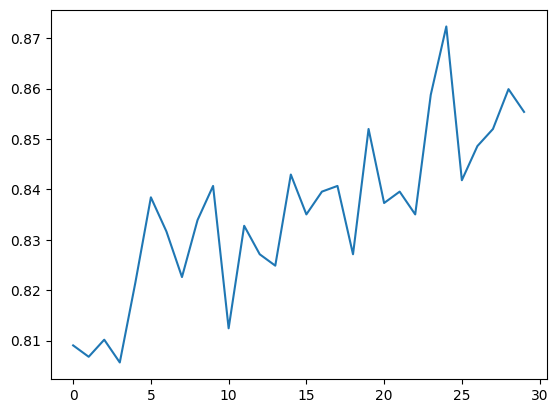

In [290]:
f = driver
l = 40
target = 'IVV_MEAN__pct'
data_lag = data.iloc[:100, :].loc[:, [f, target]].copy()
data_app = data.iloc[100:, :].loc[:, [f, target]].copy()

data_joint = pandas.concat((data_lag, data_app), axis=0, ignore_index=True)
data_joint = make_lags(frame=data_joint, nl=l)

data_joint[driver] = data_joint[driver].pct_change()

# .iloc[data_lag.shape[0]:, :]

x_factors = [c for c in data_joint.columns if ((f in c) and ('LAG' in c))]

sub_train = data_joint.iloc[l:data_lag.shape[0], :].copy()
x_sub_train = sub_train[[f]].values

nex = []
for j in range(30):
    """
    disc = KBinsDiscretizer(n_bins=j+2, strategy='quantile', encode='ordinal')
    # disc = KBinsDiscretizer(n_bins=j+2, strategy='kmeans', encode='ordinal', subsample=None)
    x_sub_train_transformed = disc.fit_transform(X=x_sub_train)
    """
    """
    tar_transformed = sub_train[target].values
    clusterable_embedding = umap.UMAP(
        n_neighbors=30,
        min_dist=0.0,
        n_components=j+2,
        random_state=42,
        densmap=False
    ).fit_transform(X=x_sub_train, y=tar_transformed)
    x_sub_train_transformed = hdbscan.HDBSCAN(
        min_samples=10,
        min_cluster_size=10,
    ).fit_predict(clusterable_embedding).reshape(-1, 1)
    """

    disc = PCA(n_components=j+2, whiten=True)
    x_sub_train_transformed = disc.fit_transform(X=sub_train[x_factors])

    ens = RandomForestRegressor()
    ens.fit(X=x_sub_train_transformed, y=sub_train[target].values)
    x_sub_train_transformed = ens.predict(X=x_sub_train_transformed).reshape(-1, 1)

    fs = pandas.DataFrame(data={'x': x_sub_train_transformed[:, 0], 'y': sub_train[target].values, 'o': sub_train[f].values})
    
    nex.append(kendalltau(x=fs['x'].values, y=fs['y'].values).statistic)
print(numpy.argmax(numpy.abs(nex)) + 2)
pyplot.plot(range(len(nex)), nex)

In [238]:
fs

,x,y,o
0,-1,-0.058968,0.000948
1,-1,-0.036089,0.008523
2,-1,-0.005211,0.000000
3,-1,0.008829,0.001878
4,-1,0.032517,0.003749
5,-1,0.040841,-0.001867
6,-1,0.024830,0.004677
7,-1,0.036416,0.005587
8,-1,0.030605,-0.004630
9,-1,0.031383,0.013953


In [ ]:

model = RandomForestRegressor()
model.fit(X=x_sub_train, y=y_sub_train)

preds = data_joint.iloc[data_lag.shape[0]:, :].copy()
preds['{0}_rf_hat'.format(f)] = model.predict(X=preds[x_factors].values)
stds = numpy.concatenate([model.predict(preds[x_factors].values).reshape(-1, 1) for tree in model.estimators_], axis=1).std(axis=1, ddof=1) / numpy.power(len(model.estimators_), 0.5)
preds['{0}_rf_hat_upper'.format(f)] = preds['{0}_rf_hat'.format(f)] + stats.t.ppf(q=0.975, df=(len(model.estimators_)-1)) * stds
preds['{0}_rf_hat_lower'.format(f)] = preds['{0}_rf_hat'.format(f)] + stats.t.ppf(q=0.025, df=(len(model.estimators_)-1)) * stds
jets = preds[['DATE', '{0}_rf_hat'.format(f), '{0}_rf_hat_upper'.format(f), '{0}_rf_hat_lower'.format(f), f]].copy()

In [46]:
jets

,DATE,JTU5300QUL_rf_hat,JTU5300QUL_rf_hat_upper,JTU5300QUL_rf_hat_lower,JTU5300QUL
200,2017-08-01,36.85,36.85,36.85,46
201,2017-09-01,35.64,35.64,35.64,31
202,2017-10-01,32.79,32.79,32.79,46
203,2017-11-01,33.08,33.08,33.08,23
204,2017-12-01,27.69,27.69,27.69,28
...,...,...,...,...,...
266,2023-02-01,37.09,37.09,37.09,42
267,2023-03-01,33.36,33.36,33.36,44
268,2023-04-01,39.95,39.95,39.95,56
269,2023-05-01,44.19,44.19,44.19,39


In [37]:
beds.shape

(71,)

In [27]:
data_joint

,DATE,JTU5300QUL,DATE_LAG1,JTU5300QUL_LAG1,DATE_LAG2,JTU5300QUL_LAG2,DATE_LAG3,JTU5300QUL_LAG3,DATE_LAG4,JTU5300QUL_LAG4,...,DATE_LAG36,JTU5300QUL_LAG36,DATE_LAG37,JTU5300QUL_LAG37,DATE_LAG38,JTU5300QUL_LAG38,DATE_LAG39,JTU5300QUL_LAG39,DATE_LAG40,JTU5300QUL_LAG40
0,2000-12-01,50,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
1,2001-01-01,80,2000-12-01,50.0,NaT,NaN,NaT,NaN,NaT,NaN,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
2,2001-02-01,29,2001-01-01,80.0,2000-12-01,50.0,NaT,NaN,NaT,NaN,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
3,2001-03-01,28,2001-02-01,29.0,2001-01-01,80.0,2000-12-01,50.0,NaT,NaN,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
4,2001-04-01,52,2001-03-01,28.0,2001-02-01,29.0,2001-01-01,80.0,2000-12-01,50.0,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,2023-02-01,42,2023-01-01,52.0,2022-12-01,35.0,2022-11-01,48.0,2022-10-01,53.0,...,2020-02-01,31.0,2020-01-01,52.0,2019-12-01,38.0,2019-11-01,46.0,2019-10-01,43.0
267,2023-03-01,44,2023-02-01,42.0,2023-01-01,52.0,2022-12-01,35.0,2022-11-01,48.0,...,2020-03-01,28.0,2020-02-01,31.0,2020-01-01,52.0,2019-12-01,38.0,2019-11-01,46.0
268,2023-04-01,56,2023-03-01,44.0,2023-02-01,42.0,2023-01-01,52.0,2022-12-01,35.0,...,2020-04-01,25.0,2020-03-01,28.0,2020-02-01,31.0,2020-01-01,52.0,2019-12-01,38.0
269,2023-05-01,39,2023-04-01,56.0,2023-03-01,44.0,2023-02-01,42.0,2023-01-01,52.0,...,2020-05-01,19.0,2020-04-01,25.0,2020-03-01,28.0,2020-02-01,31.0,2020-01-01,52.0


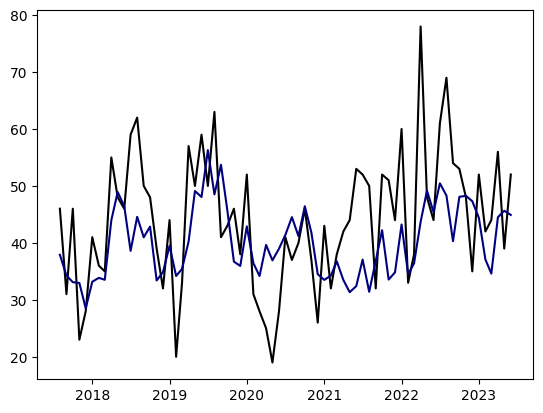

In [28]:
pyplot.plot(preds['DATE'].values, preds[f].values, 'black')
pyplot.plot(preds['DATE'].values, preds['{0}_rf_hat'.format(f)].values, 'navy')

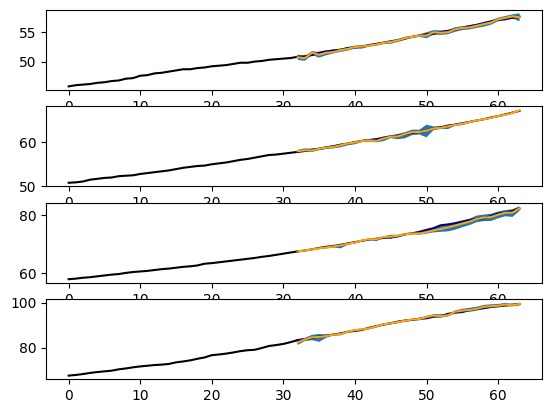

In [10]:
fig

In [11]:
y_dev

,ds,y
662,1970-02-01,45.8
663,1970-03-01,46.0
664,1970-04-01,46.1
665,1970-05-01,46.2
666,1970-06-01,46.4
...,...,...
978,1996-06-01,161.7
979,1996-07-01,162.2
980,1996-08-01,162.5
981,1996-09-01,162.9


In [29]:
jets = preds[['DATE', '{0}_rf_hat_lower'.format(f), '{0}_rf_hat_upper'.format(f), '{0}_rf_hat'.format(f)]].copy()
jets = jets.merge(right=data_joint, left_on='DATE', right_on='DATE', how='left')
jets

,DATE,JTU5300QUL_rf_hat_lower,JTU5300QUL_rf_hat_upper,JTU5300QUL_rf_hat,JTU5300QUL,DATE_LAG1,JTU5300QUL_LAG1,DATE_LAG2,JTU5300QUL_LAG2,DATE_LAG3,...,DATE_LAG36,JTU5300QUL_LAG36,DATE_LAG37,JTU5300QUL_LAG37,DATE_LAG38,JTU5300QUL_LAG38,DATE_LAG39,JTU5300QUL_LAG39,DATE_LAG40,JTU5300QUL_LAG40
0,2017-08-01,NaN,NaN,37.91,46,2017-07-01,38.0,2017-06-01,47.0,2017-05-01,...,2014-08-01,49.0,2014-07-01,38.0,2014-06-01,29.0,2014-05-01,35.0,2014-04-01,34.0
1,2017-09-01,NaN,NaN,34.28,31,2017-08-01,46.0,2017-07-01,38.0,2017-06-01,...,2014-09-01,37.0,2014-08-01,49.0,2014-07-01,38.0,2014-06-01,29.0,2014-05-01,35.0
2,2017-10-01,NaN,NaN,33.10,46,2017-09-01,31.0,2017-08-01,46.0,2017-07-01,...,2014-10-01,35.0,2014-09-01,37.0,2014-08-01,49.0,2014-07-01,38.0,2014-06-01,29.0
3,2017-11-01,NaN,NaN,32.96,23,2017-10-01,46.0,2017-09-01,31.0,2017-08-01,...,2014-11-01,41.0,2014-10-01,35.0,2014-09-01,37.0,2014-08-01,49.0,2014-07-01,38.0
4,2017-12-01,NaN,NaN,28.51,28,2017-11-01,23.0,2017-10-01,46.0,2017-09-01,...,2014-12-01,26.0,2014-11-01,41.0,2014-10-01,35.0,2014-09-01,37.0,2014-08-01,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,2023-02-01,NaN,NaN,37.09,42,2023-01-01,52.0,2022-12-01,35.0,2022-11-01,...,2020-02-01,31.0,2020-01-01,52.0,2019-12-01,38.0,2019-11-01,46.0,2019-10-01,43.0
67,2023-03-01,NaN,NaN,34.61,44,2023-02-01,42.0,2023-01-01,52.0,2022-12-01,...,2020-03-01,28.0,2020-02-01,31.0,2020-01-01,52.0,2019-12-01,38.0,2019-11-01,46.0
68,2023-04-01,NaN,NaN,44.50,56,2023-03-01,44.0,2023-02-01,42.0,2023-01-01,...,2020-04-01,25.0,2020-03-01,28.0,2020-02-01,31.0,2020-01-01,52.0,2019-12-01,38.0
69,2023-05-01,NaN,NaN,45.64,39,2023-04-01,56.0,2023-03-01,44.0,2023-02-01,...,2020-05-01,19.0,2020-04-01,25.0,2020-03-01,28.0,2020-02-01,31.0,2020-01-01,52.0


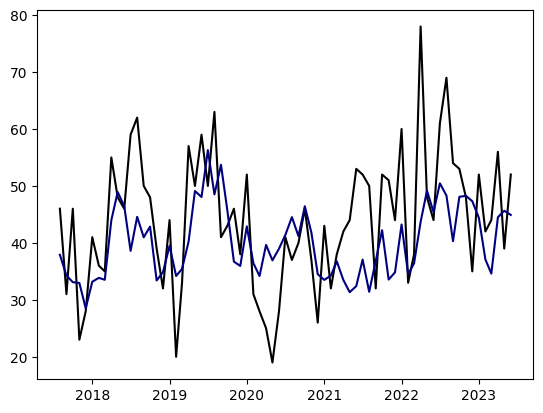

In [30]:
fig, ax = pyplot.subplots()
ax.plot(jets['DATE'].values, jets['{0}'.format(f)].values, 'black')
ax.plot(jets['DATE'].values, jets['{0}_rf_hat'.format(f)].values, 'navy')
ax.fill_between(jets['DATE'].values, jets['{0}_rf_hat_lower'.format(f)].values, jets['{0}_rf_hat_upper'.format(f)].values, alpha=0.2)

In [ ]:

data_lag = series.iloc[:200, :].copy()
data_train = series.iloc[200:400, :].copy()
data_test = series.iloc[400:, :].copy()

data_joint = pandas.concat((data_lag, data_train, data_test), axis=0, ignore_index=True)

fold_n = data_train.shape[0] + data_test.shape[0]
preds = []
for j in range(fold_n):
    y_sub = data_joint.iloc[i:data_lag.shape[0]+i].copy()
    y_pred = data_joint.iloc[[data_lag.shape[0]+i]].copy()
    
    m = Prophet(seasonality_mode='additive', interval_width=0.90, mcmc_samples=300, changepoint_prior_scale=0.005, changepoint_range=1.0)
    m.fit(y_sub)

    predictions = m.predict(y_pred)
    preds.append(predictions)
preds = pandas.concat(preds, axis=0, ignore_index=True)


04:28:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:28:21 - cmdstanpy - INFO - CmdStan done processing.
04:28:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:28:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:28:27 - cmdstanpy - INFO - CmdStan done processing.
04:28:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:28:27 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 106 iterations at max treedepth (70.7%)
	Chain 2 had 103 iterations at max treedepth (68.7%)
	Chain 3 had 112 iterations at max treedepth (74.7%)
	Chain 

04:28:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:28:34 - cmdstanpy - INFO - CmdStan done processing.
04:28:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:28:34 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:28:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:28:41 - cmdstanpy - INFO - CmdStan done processing.
04:28:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:28:41 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:28:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:28:49 - cmdstanpy - INFO - CmdStan done processing.
04:28:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:28:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:28:56 - cmdstanpy - INFO - CmdStan done processing.
04:28:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:28:56 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:28:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:29:03 - cmdstanpy - INFO - CmdStan done processing.
04:29:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:29:03 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 125 iterations at max treedepth (83.3%)
	Chain 2 had 120 iterations at max treedepth (80.0%)
	Chain 3 had 105 iterations at max treedepth (70.0%)
	Chain 

04:29:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:29:10 - cmdstanpy - INFO - CmdStan done processing.
04:29:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:29:10 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:29:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:29:17 - cmdstanpy - INFO - CmdStan done processing.
04:29:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:29:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:29:24 - cmdstanpy - INFO - CmdStan done processing.
04:29:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:29:24 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:29:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:29:32 - cmdstanpy - INFO - CmdStan done processing.
04:29:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:29:32 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 119 iterations at max treedepth (79.3%)
	Chain 2 had 128 iterations at max treedepth (85.3%)
	Chain 3 had 127 iterations at max treedepth (84.7%)
	Chain 

04:29:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:29:39 - cmdstanpy - INFO - CmdStan done processing.
04:29:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:29:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:29:46 - cmdstanpy - INFO - CmdStan done processing.
04:29:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:29:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:29:53 - cmdstanpy - INFO - CmdStan done processing.
04:29:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:29:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:30:00 - cmdstanpy - INFO - CmdStan done processing.
04:30:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:30:00 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:30:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:30:08 - cmdstanpy - INFO - CmdStan done processing.
04:30:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:30:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:30:15 - cmdstanpy - INFO - CmdStan done processing.
04:30:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:30:15 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:30:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:30:22 - cmdstanpy - INFO - CmdStan done processing.
04:30:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:30:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:30:29 - cmdstanpy - INFO - CmdStan done processing.
04:30:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:30:29 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:30:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:30:36 - cmdstanpy - INFO - CmdStan done processing.
04:30:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Except

04:30:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:30:44 - cmdstanpy - INFO - CmdStan done processing.
04:30:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:30:44 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 111 iterations at max treedepth (74.0%)
	Chain 2 had 91 iterations at max treedepth (60.7%)
	Chain 3 had 94 iterations at max treedepth (62.7%)
	Chain 4 

04:30:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:30:52 - cmdstanpy - INFO - CmdStan done processing.
04:30:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:30:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:31:00 - cmdstanpy - INFO - CmdStan done processing.
04:31:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:31:00 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 116 iterations at max treedepth (77.3%)
	Chain 2 had 112 iterations at max treedepth (74.7%)
	Chain 3 had 116 iterations at max treedepth (77.3%)
	Chain 

04:31:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:31:07 - cmdstanpy - INFO - CmdStan done processing.
04:31:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Except

04:31:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:31:15 - cmdstanpy - INFO - CmdStan done processing.
04:31:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:31:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:31:23 - cmdstanpy - INFO - CmdStan done processing.
04:31:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:31:23 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:31:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:31:30 - cmdstanpy - INFO - CmdStan done processing.
04:31:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:31:30 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:31:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:31:38 - cmdstanpy - INFO - CmdStan done processing.
04:31:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:31:38 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 108 iterations at max treedepth (72.0%)
	Chain 2 had 115 iterations at max treedepth (76.7%)
	Chain 3 had 122 iterations at max treedepth (81.3%)
	Chain 

04:31:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:31:46 - cmdstanpy - INFO - CmdStan done processing.
04:31:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:31:46 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:31:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:31:53 - cmdstanpy - INFO - CmdStan done processing.
04:31:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:31:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:32:01 - cmdstanpy - INFO - CmdStan done processing.
04:32:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:32:01 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 94 iterations at max treedepth (62.7%)
	Chain 2 had 126 iterations at max treedepth (84.0%)
	Chain 3 had 115 iterations at max treedepth (76.7%)
	Chain 4

04:32:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:32:08 - cmdstanpy - INFO - CmdStan done processing.
04:32:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:32:08 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:32:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:32:16 - cmdstanpy - INFO - CmdStan done processing.
04:32:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:32:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:32:24 - cmdstanpy - INFO - CmdStan done processing.
04:32:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:32:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:32:31 - cmdstanpy - INFO - CmdStan done processing.
04:32:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:32:31 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:32:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:32:38 - cmdstanpy - INFO - CmdStan done processing.
04:32:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:32:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:32:46 - cmdstanpy - INFO - CmdStan done processing.
04:32:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:32:46 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 125 iterations at max treedepth (83.3%)
	Chain 2 had 118 iterations at max treedepth (78.7%)
	Chain 3 had 111 iterations at max treedepth (74.0%)
	Chain 

04:32:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:32:53 - cmdstanpy - INFO - CmdStan done processing.
04:32:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:32:54 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:32:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:33:01 - cmdstanpy - INFO - CmdStan done processing.
04:33:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:33:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:33:09 - cmdstanpy - INFO - CmdStan done processing.
04:33:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:33:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:33:16 - cmdstanpy - INFO - CmdStan done processing.
04:33:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:33:16 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:33:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:33:23 - cmdstanpy - INFO - CmdStan done processing.
04:33:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:33:23 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:33:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:33:31 - cmdstanpy - INFO - CmdStan done processing.
04:33:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Except

04:33:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:33:38 - cmdstanpy - INFO - CmdStan done processing.
04:33:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:33:38 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:33:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:33:45 - cmdstanpy - INFO - CmdStan done processing.
04:33:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:33:45 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:33:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:33:53 - cmdstanpy - INFO - CmdStan done processing.
04:33:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:33:53 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:33:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:34:00 - cmdstanpy - INFO - CmdStan done processing.
04:34:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:34:00 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:34:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:34:08 - cmdstanpy - INFO - CmdStan done processing.
04:34:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:34:08 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 110 iterations at max treedepth (73.3%)
	Chain 2 had 126 iterations at max treedepth (84.0%)
	Chain 3 had 114 iterations at max treedepth (76.0%)
	Chain 

04:34:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:34:15 - cmdstanpy - INFO - CmdStan done processing.
04:34:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:34:15 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:34:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:34:23 - cmdstanpy - INFO - CmdStan done processing.
04:34:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:34:23 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:34:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:34:31 - cmdstanpy - INFO - CmdStan done processing.
04:34:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:34:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:34:38 - cmdstanpy - INFO - CmdStan done processing.
04:34:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:34:38 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:34:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:34:46 - cmdstanpy - INFO - CmdStan done processing.
04:34:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:34:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:34:53 - cmdstanpy - INFO - CmdStan done processing.
04:34:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:34:53 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 122 iterations at max treedepth (81.3%)
	Chain 2 had 122 iterations at max treedepth (81.3%)
	Chain 3 had 131 iterations at max treedepth (87.3%)
	Chain 

04:34:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:35:01 - cmdstanpy - INFO - CmdStan done processing.
04:35:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:35:01 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:35:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:35:09 - cmdstanpy - INFO - CmdStan done processing.
04:35:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:35:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:35:16 - cmdstanpy - INFO - CmdStan done processing.
04:35:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:35:16 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:35:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:35:24 - cmdstanpy - INFO - CmdStan done processing.
04:35:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:35:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:35:31 - cmdstanpy - INFO - CmdStan done processing.
04:35:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:35:31 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:35:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:35:39 - cmdstanpy - INFO - CmdStan done processing.
04:35:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:35:39 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:35:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:35:46 - cmdstanpy - INFO - CmdStan done processing.
04:35:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:35:46 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:35:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:35:54 - cmdstanpy - INFO - CmdStan done processing.
04:35:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Except

04:35:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:36:02 - cmdstanpy - INFO - CmdStan done processing.
04:36:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:36:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:36:10 - cmdstanpy - INFO - CmdStan done processing.
04:36:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:36:10 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:36:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:36:17 - cmdstanpy - INFO - CmdStan done processing.
04:36:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:36:17 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:36:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:36:25 - cmdstanpy - INFO - CmdStan done processing.
04:36:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Except

04:36:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:36:32 - cmdstanpy - INFO - CmdStan done processing.
04:36:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:36:32 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 117 iterations at max treedepth (78.0%)
	Chain 2 had 125 iterations at max treedepth (83.3%)
	Chain 3 had 106 iterations at max treedepth (70.7%)
	Chain 

04:36:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [726]:
# from prophet.plot import plot_plotly, plot_components_plotly

# plot_plotly(m, forecast)

In [460]:
# plot_components_plotly(m, forecast)